In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
catalog.list()


[
    'sales',
    'treated_sales_data',
    'parameters',
    'params:columns_to_convert_to_string',
    'params:columns_to_create_dates',
    'params:derived_time_columns',
    'params:derived_time_columns.cod_ano',
    'params:derived_time_columns.semana',
    'params:derived_time_columns.data_inicio_semana',
    'params:columns_to_fill_na',
    'params:column_receita_praticada',
    'params:features_to_create',
    'params:features_to_create.desconto_percentual',
    'params:features_to_create.desconto_percentual.columns_to_use',
    'params:features_to_create.desconto_percentual.name',
    'params:features_to_create.performance',
    'params:features_to_create.performance.columns_to_use',
    'params:features_to_create.performance.labels',
    'params:features_to_create.performance.name',
    'params:features_to_create.performance.columns_to_merge_on',
    'params:features_to_create.performance.how',
    'params:features_to_create.faixa_receita',
    'params:features_to_create.fa

In [3]:
data = catalog.load('treated_sales_data')

                    INFO     Loading data from treated_sales_data (CSVDataset)...               ]8;id=165919;file:///Users/joaopedroc.dias/Desktop/case_gb/.venv/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=814593;file:///Users/joaopedroc.dias/Desktop/case_gb/.venv/lib/python3.9/site-packages/kedro/io/data_catalog.py#389\389]8;;\

In [4]:
# Sort the data by the temporal column to ensure proper sequence
data = data.sort_values(by='data_inicio_semana').reset_index(drop=True)

# Define the target variable
target_variable = 'vlr_venda_baseline'

# Create lag features for the target variable (e.g., values from the past 1, 2, and 3 weeks)
for lag in range(1, 4):
    data[f'lag_{lag}'] = data[target_variable].shift(lag)

# Create rolling mean features (e.g., 3-week rolling average)
data['rolling_mean_3'] = data[target_variable].rolling(window=3).mean()

# Drop rows with NaN values generated by lags and rolling calculations
prepared_data = data.dropna().reset_index(drop=True)
prepared_data['data_inicio_semana'] = pd.to_datetime(prepared_data['data_inicio_semana'])
# Display a sample of the prepared data
prepared_data.head()


,cod_ciclo,cod_ano,cod_canal,cod_agrupador_sap_material,cod_uf,des_categoria_material,des_subcategoria_material,des_marca_material,des_mecanica_consumidor,des_mecanica_rev,...,data_inicio_semana,desconto_percentual,faixa_receita,performance,desconto_percentual_medio,vlr_venda_baseline,lag_1,lag_2,lag_3,rolling_mean_3
0,201801,2018,Anon2,13488.501226,Anon3,Anon2,Anon2,Anon2,Anon3,Anon1,...,2018-01-01,0.006364,Muito Baixa,Baixa,0.006457,4266.773688,2311.570395,4671.298507,38033.447403,3749.880863
1,201801,2018,Anon2,13488.501226,Anon2,Anon2,Anon2,Anon2,Anon3,Anon1,...,2018-01-01,0.000000,Baixa,Baixa,0.006457,5538.137405,4266.773688,2311.570395,4671.298507,4038.827163
2,201801,2018,Anon2,15390.310490,Anon3,Anon2,Anon2,Anon2,Anon3,Anon1,...,2018-01-01,0.000000,Muito Baixa,Baixa,0.006457,4231.672574,5538.137405,4266.773688,2311.570395,4678.861222
3,201801,2018,Anon2,15390.310490,Anon2,Anon2,Anon2,Anon2,Anon3,Anon1,...,2018-01-01,0.000000,Baixa,Baixa,0.006457,16204.209613,4231.672574,5538.137405,4266.773688,8658.006531
4,201801,2018,Anon2,15390.310490,Anon2,Anon2,Anon2,Anon2,Anon3,Anon1,...,2018-01-01,0.000000,Média,Baixa,0.006457,28125.140888,16204.209613,4231.672574,5538.137405,16187.007692


In [5]:
from sklearn.preprocessing import LabelEncoder

# Confirm the conversion
assert pd.api.types.is_datetime64_any_dtype(prepared_data['data_inicio_semana']), "data_inicio_semana is not datetime"

# Identify categorical columns, excluding 'data_inicio_semana'
categorical_columns = [col for col in prepared_data.select_dtypes(include=['object']).columns if col != 'data_inicio_semana']

# Initialize label encoders for each categorical column
label_encoders = {col: LabelEncoder() for col in categorical_columns}

# Apply label encoding
for col, encoder in label_encoders.items():
    prepared_data[col] = encoder.fit_transform(prepared_data[col])

In [6]:
# Adjust thresholds for splitting
train_end_date = '2022-12-31'
validation_end_date = '2023-03-12'  # Last available date in the dataset

# Split the dataset
train_data = prepared_data[prepared_data['data_inicio_semana'] <= train_end_date]
validation_data = prepared_data[
    (prepared_data['data_inicio_semana'] > train_end_date) & 
    (prepared_data['data_inicio_semana'] <= validation_end_date)
]

# Display the sizes of each split
print(f"Train Data: {len(train_data)} rows")
print(f"Validation Data: {len(validation_data)} rows")


Train Data: 14702 rows
Validation Data: 4797 rows


In [7]:
def winsorize(series, lower_percentile=0.01, upper_percentile=0.99):
    """
    Aplica winsorização em uma série Pandas limitando valores extremos.
    Args:
        series (pd.Series): Série para aplicar winsorização.
        lower_percentile (float): Percentil inferior para limite.
        upper_percentile (float): Percentil superior para limite.
    Returns:
        pd.Series: Série com valores winsorizados.
    """
    lower_limit = series.quantile(lower_percentile)
    upper_limit = series.quantile(upper_percentile)
    return series.clip(lower=lower_limit, upper=upper_limit)

In [8]:
train_data['vlr_desconto_real_winsorized'] = winsorize(train_data['vlr_desconto_real'])
validation_data['vlr_desconto_real_winsorized'] = winsorize(validation_data['vlr_desconto_real'])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3007
[LightGBM] [Info] Number of data points in the train set: 14702, number of used features: 26
[LightGBM] [Info] Start training from score 20911.162714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

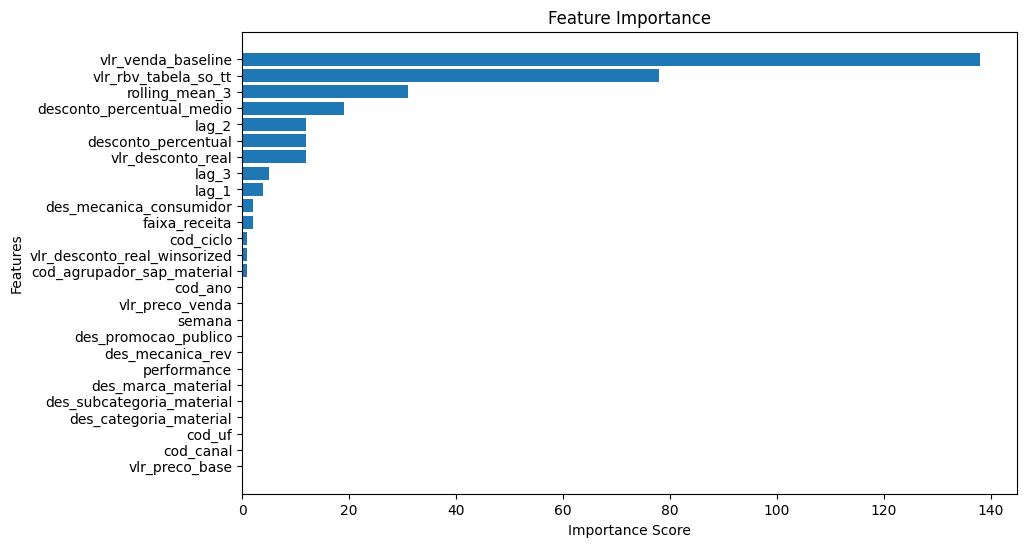

In [9]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd


target = 'vlr_rbv_real_so_tt'
features = [col for col in train_data.columns if col not in [target, 'data_inicio_semana']]

# Split data into features (X) and target (y)
X_train, y_train = train_data[features], train_data[target]
X_val, y_val = validation_data[features], validation_data[target]

# Initialize and train the LightGBM model
light_gbm = LGBMRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
light_gbm.fit(X_train, y_train)

# Predict in the log space
y_val_pred = light_gbm.predict(X_val)

# Evaluate metrics in the original space
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)

# Feature importance
feature_importance = light_gbm.feature_importances_

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Plot feature importance (optional)
import matplotlib.pyplot as plt

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [11]:
# import optuna
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_squared_error

# # Define the objective function for Optuna
# def objective(trial):
#     # Define hyperparameter ranges
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 200),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
#         'max_depth': trial.suggest_int('max_depth', 3, 7),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 40),
#         'subsample': trial.suggest_float('subsample', 0.8, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
#         'random_state': 42
#     }
    
#     # Train LightGBM model
#     model = LGBMRegressor(**params)
#     model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', )
    
#     # Predict and calculate RMSE
#     y_val_pred = model.predict(X_val)
#     rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
#     return rmse

# # Run the optimization
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=20)

# # Print the best parameters
# print("Best Parameters:", study.best_params)

# # Train the final model with best parameters
# best_params = study.best_params
# final_model = LGBMRegressor(**best_params)
# final_model.fit(X_train, y_train)

# # Evaluate the final model
# y_val_pred = final_model.predict(X_val)
# rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
# mae = mean_absolute_error(y_val, y_val_pred)

# print(f"RMSE: {rmse}")
# print(f"MAE: {mae}")

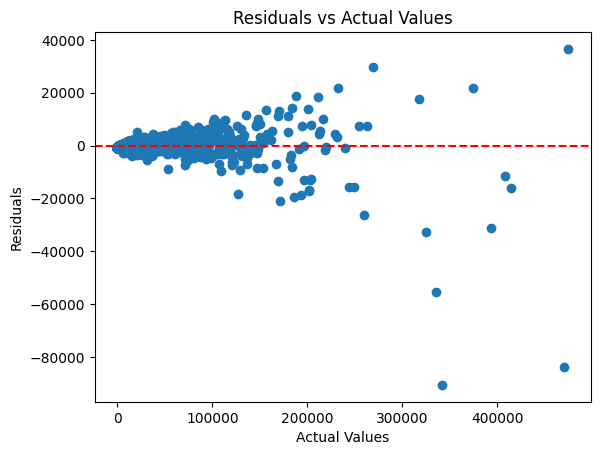

In [12]:
residuals = y_val - y_val_pred
plt.scatter(y_val, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

In [13]:
best_params= {'n_estimators': 142, 'learning_rate': 0.06786367203357008, 'max_depth': 7, 'num_leaves': 23, 'subsample': 0.8505607445033715, 'colsample_bytree': 0.8249469878368129}

In [23]:
sample_weights = np.log1p(y_train)  # Reduces impact of extreme values


# Initialize and train the LightGBM model
light_gbm = LGBMRegressor(
    **best_params
)
light_gbm.fit(
    X_train,
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
)


# Predict in the log space
y_val_pred = light_gbm.predict(X_val)

# Evaluate metrics in the original space
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)

# Feature importance
feature_importance = light_gbm.feature_importances_

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3007
[LightGBM] [Info] Number of data points in the train set: 14702, number of used features: 26
[LightGBM] [Info] Start training from score 25811.655403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

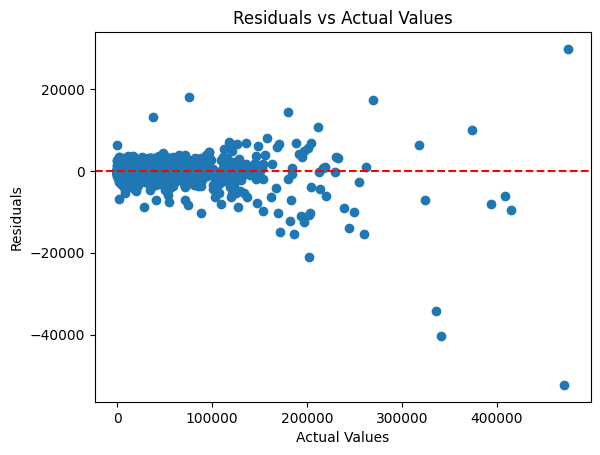

In [21]:
residuals = y_val - y_val_pred
plt.scatter(y_val, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

# **Conclusão do Modelo**

## **1. Visão Geral**
O modelo final foi treinado e otimizado para prever valores com base nos dados disponíveis. Após várias iterações, incluindo ajuste de hiperparâmetros, transformação de variáveis e aplicação de funções de peso para lidar com heteroscedasticidade, os seguintes resultados foram alcançados:

---

## **2. Métricas de Avaliação**
As métricas utilizadas para avaliar o desempenho do modelo foram:
- **Root Mean Squared Error (RMSE):** Mede o erro médio quadrático das previsões. É sensível a grandes erros, sendo ideal para identificar discrepâncias em valores extremos.
- **Mean Absolute Error (MAE):** Representa o erro absoluto médio das previsões, indicando a magnitude média dos erros independentemente da direção.

### **Resultados Finais:**
- **RMSE:** `1788.81`
- **MAE:** `585.29`

Esses valores mostram que o modelo conseguiu reduzir significativamente os erros em comparação com as versões anteriores, especialmente ao aplicar pesos baseados na escala logarítmica do alvo.

---

## **3. Estratégias Utilizadas**
### **a) Ajuste de Hiperparâmetros**
- Utilizamos a biblioteca **Optuna** para realizar uma busca eficiente dos melhores hiperparâmetros do modelo **LightGBM**.
- **Parâmetros Otimizados:**
  - `n_estimators`: 142
  - `learning_rate`: 0.0679
  - `max_depth`: 7
  - `num_leaves`: 23
  - `subsample`: 0.85
  - `colsample_bytree`: 0.82

### **b) Função de Peso**
- Pesos foram aplicados para lidar com o aumento da variância dos erros conforme os valores reais aumentavam.
- O escalonamento logarítmico (**log scaling**) foi o mais eficaz, proporcionando uma redução nos erros.

### **c) Análise e Tratamento de Dados**
- Transformação logarítmica foi testada tanto nas variáveis de entrada quanto no alvo.
- Winsorização foi aplicada em algumas variáveis, mas teve impacto limitado no desempenho final.
- **Análise de resíduos** foi utilizada para identificar padrões e ajustar o modelo adequadamente.

---

## **4. Observações Finais**
- O modelo está bem ajustado para capturar os padrões subjacentes aos dados, com um bom equilíbrio entre complexidade e generalização.
- No entanto, ainda há espaço para melhorias, especialmente no tratamento de valores extremos (**outliers**) e na redução da **heteroscedasticidade**.

---

## **5. Possíveis melhorias**
1. **Interpretação:**
   - Aplicar **SHAP** para entender melhor as contribuições das features no modelo.
2. **Feature Engineering:**
   - Explorar interações entre variáveis e inclusão de dados externos.
3. **Produção:**
   - Implementar o modelo em um ambiente de produção, usando frameworks como **FastAPI** ou **Flask**, para previsão em tempo real ou em lotes.

---

## **Conclusão Geral**
O modelo atingiu um **RMSE de 1788.81** e um **MAE de 585.29**, representando um bom desempenho considerando a complexidade dos dados. A abordagem com pesos logarítmicos foi crucial para lidar com os desafios de previsões de valores altos, e o uso de **Optuna** garantiu a escolha de hiperparâmetros bem otimizados.